<a href="https://colab.research.google.com/github/waltermaffy/ESP-ATTENDANCE/blob/master/DCGAN/WGAN/WGAN_GP_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WASSERSTEIN GAN with GRADIENT PENALTY
code partially taken from https://github.com/EmilienDupont/wgan-gp

In [0]:
import imageio
import numpy as np
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision.utils as vutils
import time
import matplotlib.pyplot as plt
from google.colab import drive
from pathlib import Path

# PARAMETERS

In [0]:
batch_size = 64 
dataset_name = 'MNIST'  # Possible datasets [MNIST, FASHION, LSUN, CELEBA, CIFAR10]
img_size = (32,32,1)
lr = 2e-4
betas = (.5, .99)
epochs = 140
ngpu = 1
weights_backup = True #Save weights during training
weights_restore = False #Set to False if want to restart training from zero

In [0]:
if weights_backup: 
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/TESI/TESI GAN/Maffione/Colab/DCGAN basic/WGAN-GP/'
  image_path = path + 'images/' + dataset_name 
  checkpoint_file = path + 'weights/checkpt_' + dataset_name + '.pt'
  checkpoint_file_half = path + 'weights/checkpt_' + dataset_name + '-' + str(int(epochs/2)) + '.pt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA LOADER

Dataset MNIST contains 60000 images


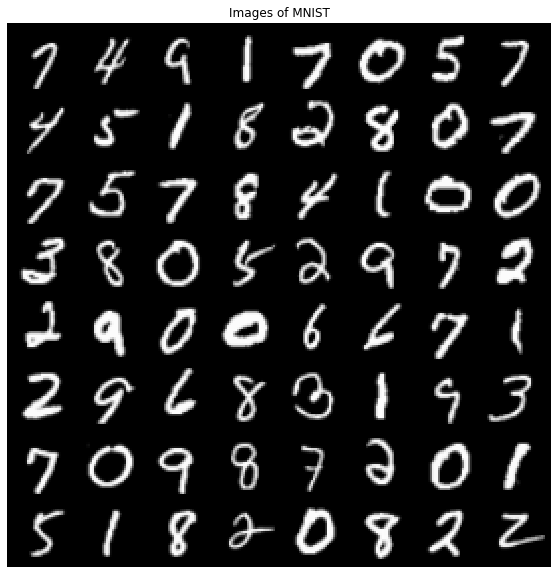

In [0]:
transform=transforms.Compose([
                               transforms.Resize(img_size[0]),
                               transforms.CenterCrop(img_size[0]),
                               transforms.ToTensor(),
       #                        transforms.Normalize([0.5], [0.5])
                               ])

if dataset_name == 'CIFAR10':
  dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
elif dataset_name == 'LSUN':
  dataset = datasets.LSUN(root='./data',classes=['bedroom_train'], transform=transforms)
elif dataset_name== 'CELEBA':
  dataset = datasets.CelebA(root='./data', download=True, transform=transform)
elif  dataset_name== 'MNIST':
  dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
elif  dataset_name== 'FASHION':
  dataset = datasets.FashionMNIST(root='./data', download=True, transform=transform)


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1,pin_memory=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Images of {}".format(dataset_name))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

print('Dataset {} contains {} images'.format(dataset_name, len(dataset)))

# MODELS

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, dim):
        super(Generator, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.feature_sizes = (int(self.img_size[0] / 16), int(self.img_size[1] / 16))

        self.latent_to_features = nn.Sequential(
            nn.Linear(latent_dim, 8 * dim * self.feature_sizes[0] * self.feature_sizes[1]),
            nn.ReLU()
        )

        self.features_to_image = nn.Sequential(
            nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(4 * dim),
            nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(2 * dim),
            nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(dim),
            nn.ConvTranspose2d(dim, self.img_size[2], 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        # Map latent into appropriate size for transposed convolutions
        x = self.latent_to_features(input_data)
        # Reshape
        x = x.view(-1, 8 * self.dim, self.feature_sizes[0], self.feature_sizes[1])
        # Return generated image
        return self.features_to_image(x)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.latent_dim))


class Discriminator(nn.Module):
    def __init__(self, img_size, dim):
        """
        img_size : (int, int, int)
            Height and width must be powers of 2.  E.g. (32, 32, 1) or
            (64, 128, 3). Last number indicates number of channels, e.g. 1 for
            grayscale or 3 for RGB
        """
        super(Discriminator, self).__init__()

        self.img_size = img_size

        self.image_to_features = nn.Sequential(
            nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim, 2 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4 * dim, 8 * dim, 4, 2, 1),
            nn.Sigmoid()
        )

        # 4 convolutions of stride 2, i.e. halving of size everytime
        # So output size will be 8 * (img_size / 2 ^ 4) * (img_size / 2 ^ 4)
        output_size = 8 * dim * (int(img_size[0] / 16)) * (int(img_size[1] / 16))
        self.features_to_prob = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        batch_size = input_data.size()[0]
        x = self.image_to_features(input_data)
        x = x.view(batch_size, -1)
        return self.features_to_prob(x)


#define models
generator = Generator(img_size=img_size, latent_dim=100, dim=16).apply(weights_init)
discriminator = Discriminator(img_size=img_size, dim=16)

print(generator)
print(discriminator)

Generator(
  (latent_to_features): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU()
  )
  (features_to_image): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Sigmoid()
  )
)
Discriminator(
  (image_to_features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0

# GAN MODEL

In [0]:
class GAN():
    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=499,
                 use_cuda=False):
        self.G = generator
        self.G_opt = gen_optimizer
        self.D = discriminator
        self.D_opt = dis_optimizer
        self.losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.start_epoch = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.training_progress_images = []

        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

    def _critic_train_iteration(self, data):
        
        # Get generated data
        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        # Calculate probabilities on real and generated data
        data = Variable(data)
        if self.use_cuda:
            data = data.cuda()
        d_real = self.D(data)
        d_generated = self.D(generated_data)

        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.D_opt.zero_grad()
        d_loss = d_generated.mean() - d_real.mean() + gradient_penalty
        d_loss.backward()

        self.D_opt.step()

        # Record loss
        self.losses['D'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        """ """
        self.G_opt.zero_grad()

        # Get generated data
        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        # Calculate loss and optimize
        d_generated = self.D(generated_data)
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.G_opt.step()

        # Record loss
        self.losses['G'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = self.D(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height), so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())
        # Derivatives of the gradient close to 0 can cause problems because of the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader,epoch):
        for i, data in enumerate(data_loader):
            self.num_steps += 1
            self._critic_train_iteration(data[0])
            # Only update generator every |critic_iterations| iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data[0])
        print("[%d/%d]\tD_loss: %.2f,\tG_loss: %.2f,\t[GP: %.2f, Gradient norm: %.2f]" % (epoch, epochs, self.losses['D'][-1], self.losses['G'][-1], self.losses['GP'][-1], self.losses['gradient_norm'][-1] ) )
    
    def train(self, data_loader, epochs, show_results=True):
        if show_results:
            # Fix latents to see how image generation improves during training
            fixed_latents = Variable(self.G.sample_latent(64))
            if self.use_cuda:
                fixed_latents = fixed_latents.cuda()
          
        if weights_restore:
          self.restore_checkpoint(checkpoint_file)
         
        print('###########   START TRAINING   ############')
        start = time.time()

        for epoch in range(epochs-self.start_epoch):
            epoch+=self.start_epoch

            self._train_epoch(data_loader, epoch)
            
            if show_results and epoch % 5 == 0:
                img_grid = make_grid(self.G(fixed_latents).cpu().data) # Generate batch of images and convert to grid
                img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))   # Convert to numpy and transpose axes to fit imageio convention i.e. (width, height, channels)
                self.training_progress_images.append(img_grid)         # Add image grid to training progress
          
                self.plot_epoch(epoch, img_grid)


            if weights_backup and epoch % 5 == 0:
                self.store_checkpoint(epoch, checkpoint_file)

            #Save a checkpoint also at half of the training
            if weights_backup and epoch == (int(epochs/2)):
              self.store_checkpoint(epoch, checkpoint_file_half)

        end = time.time()
        #Save GIF
        imageio.mimsave(image_path+'_GIF_{}epochs.gif'.format(epochs),self.training_progress_images)
        
        print('Total training time: {} min, {} sec '.format(int((end - start) / 60), int((end - start) % 60)))
        
        #Save and Plot final results
        self.plot_save_generated(epoch, save=True)
        self.plot_save_losses()
           
    def sample_generator(self, num_samples):
        latent_samples = Variable(self.G.sample_latent(num_samples))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples)
        return generated_data

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        # Remove color channel
        return generated_data.data.cpu().numpy()[:, 0, :, :]

    def plot_epoch(self, epoch, img_grid):
        plt.figure(figsize=(7,7))
        plt.imshow(img_grid)
        plt.axis('off')
        plt.title('Generated images after epoch {}'.format((epoch)))
        plt.show()

    def plot_save_generated(self, epoch=epochs, save=False):
        latents = Variable(self.G.sample_latent(64)).cuda()
        img = make_grid(self.G(latents).cpu().data)
        img = np.transpose(img.numpy(), (1, 2, 0))
        plt.figure(figsize=(7,7))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Generated images after {} epochs'.format((epoch+1)))
        if save:
          plt.savefig(image_path + '_generated_%d.png' % (epoch+1))
        plt.show()
        
    def plot_save_losses(self):
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Losses During Training")
        plt.plot(self.losses['G'],label="G")
        plt.plot(self.losses['D'],label="D")
        #plt.plot(self.losses['GP'],label="GP")
        #plt.plot(self.losses['gradient_norm'],label="gradien_norm")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(image_path + '_losses.png')
        plt.show()

    def store_checkpoint(self, epoch, checkpoint_file):
      torch.save({'epoch': epoch,
                  'generator': self.G.state_dict(),
                  'discriminator': self.D.state_dict(),
                  'optimizerG': self.G_opt.state_dict(),
                  'optimizerD': self.D_opt.state_dict(),
                  'loss': self.losses,
                  'images_gen': self.training_progress_images
                  }, checkpoint_file)
        
      print('Saved checkpoint at epoch: ', epoch)

    def restore_checkpoint(self,checkpoint_file):
        if Path(checkpoint_file).exists():
          checkpoint = torch.load(checkpoint_file)
          self.G.load_state_dict(checkpoint['generator'])
          self.D.load_state_dict(checkpoint['discriminator'])
          self.G_opt.load_state_dict(checkpoint['optimizerG'])
          self.D_opt.load_state_dict(checkpoint['optimizerD'])
          self.losses = checkpoint['loss']
          self.training_progress_images = checkpoint['images_gen']
          self.start_epoch = checkpoint['epoch']
          print('Checkpoint found and restored at epoch {}'.format(self.start_epoch))
        else: 
          print('Checkpoint not used or not exist\n')



# MAIN 

###########   START TRAINING   ############
[0/140]	D_loss: -0.20,	G_loss: -0.32,	[GP: 0.34, Gradient norm: 0.96]


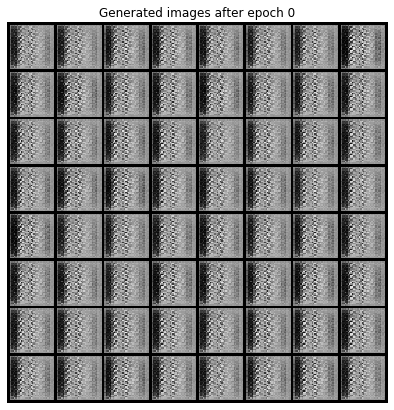

Saved checkpoint at epoch:  0
[1/140]	D_loss: -0.55,	G_loss: -0.26,	[GP: 0.10, Gradient norm: 0.97]
[2/140]	D_loss: -0.56,	G_loss: -0.21,	[GP: 0.12, Gradient norm: 0.99]
[3/140]	D_loss: -0.58,	G_loss: -0.26,	[GP: 0.10, Gradient norm: 0.96]
[4/140]	D_loss: -0.55,	G_loss: -0.25,	[GP: 0.11, Gradient norm: 0.98]
[5/140]	D_loss: -0.56,	G_loss: -0.19,	[GP: 0.09, Gradient norm: 1.03]


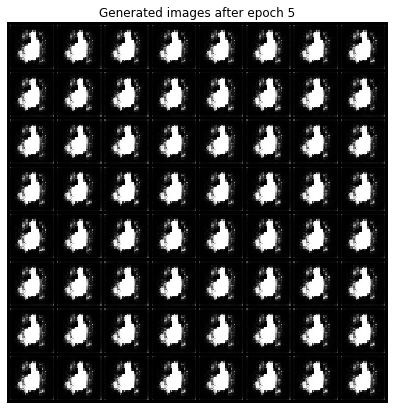

Saved checkpoint at epoch:  5
[6/140]	D_loss: -0.53,	G_loss: -0.19,	[GP: 0.09, Gradient norm: 0.98]
[7/140]	D_loss: -0.22,	G_loss: -0.27,	[GP: 0.37, Gradient norm: 0.95]
[8/140]	D_loss: -0.55,	G_loss: -0.18,	[GP: 0.10, Gradient norm: 1.02]
[9/140]	D_loss: -0.65,	G_loss: -0.17,	[GP: 0.05, Gradient norm: 1.00]
[10/140]	D_loss: -0.59,	G_loss: -0.23,	[GP: 0.07, Gradient norm: 0.97]


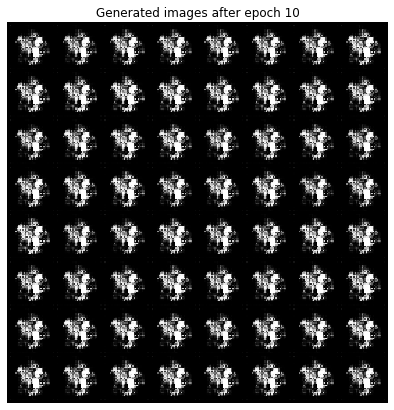

Saved checkpoint at epoch:  10
[11/140]	D_loss: -0.60,	G_loss: -0.19,	[GP: 0.09, Gradient norm: 1.02]
[12/140]	D_loss: -0.44,	G_loss: -0.14,	[GP: 0.29, Gradient norm: 0.97]
[13/140]	D_loss: -0.72,	G_loss: -0.13,	[GP: 0.08, Gradient norm: 1.00]
[14/140]	D_loss: -0.62,	G_loss: -0.14,	[GP: 0.16, Gradient norm: 0.99]
[15/140]	D_loss: -0.06,	G_loss: -0.26,	[GP: 0.42, Gradient norm: 1.01]


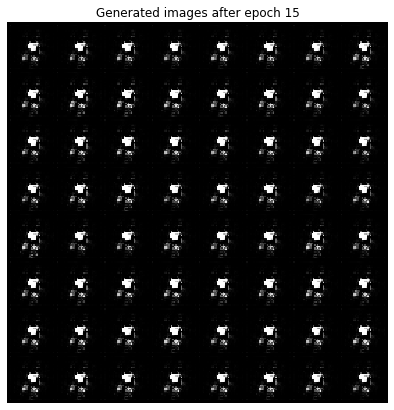

Saved checkpoint at epoch:  15
[16/140]	D_loss: -0.46,	G_loss: -0.16,	[GP: 0.04, Gradient norm: 1.00]
[17/140]	D_loss: -0.44,	G_loss: -0.12,	[GP: 0.28, Gradient norm: 0.97]
[18/140]	D_loss: -0.55,	G_loss: -0.15,	[GP: 0.11, Gradient norm: 1.00]
[19/140]	D_loss: -0.65,	G_loss: -0.18,	[GP: 0.05, Gradient norm: 0.99]
[20/140]	D_loss: -0.60,	G_loss: -0.37,	[GP: 0.06, Gradient norm: 1.00]


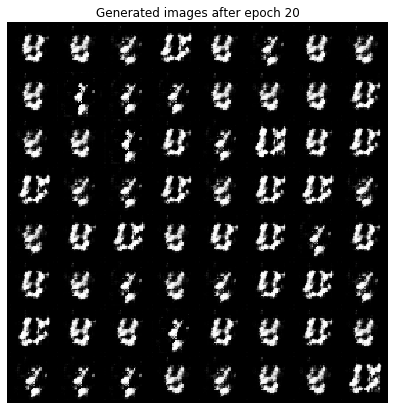

Saved checkpoint at epoch:  20
[21/140]	D_loss: -0.54,	G_loss: -0.21,	[GP: 0.06, Gradient norm: 1.02]
[22/140]	D_loss: -0.40,	G_loss: -0.26,	[GP: 0.04, Gradient norm: 1.02]
[23/140]	D_loss: -0.64,	G_loss: -0.11,	[GP: 0.04, Gradient norm: 0.98]
[24/140]	D_loss: -0.51,	G_loss: -0.15,	[GP: 0.04, Gradient norm: 1.00]
[25/140]	D_loss: -0.47,	G_loss: -0.17,	[GP: 0.04, Gradient norm: 0.99]


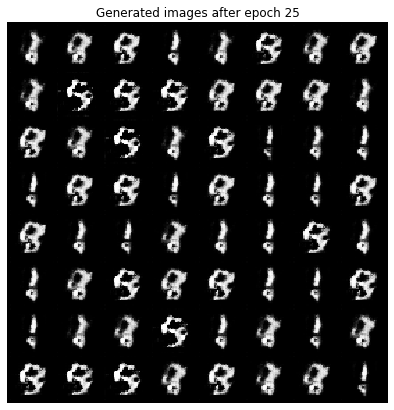

Saved checkpoint at epoch:  25
[26/140]	D_loss: -0.52,	G_loss: -0.26,	[GP: 0.08, Gradient norm: 0.95]
[27/140]	D_loss: -0.48,	G_loss: -0.20,	[GP: 0.17, Gradient norm: 1.02]
[28/140]	D_loss: -0.46,	G_loss: -0.18,	[GP: 0.18, Gradient norm: 1.01]
[29/140]	D_loss: -0.60,	G_loss: -0.18,	[GP: 0.03, Gradient norm: 1.00]
[30/140]	D_loss: -0.47,	G_loss: -0.36,	[GP: 0.03, Gradient norm: 1.00]


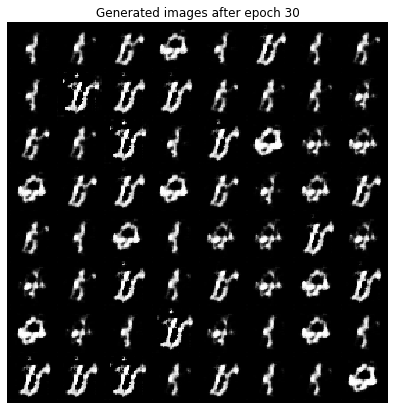

Saved checkpoint at epoch:  30
[31/140]	D_loss: -0.55,	G_loss: -0.20,	[GP: 0.03, Gradient norm: 1.04]
[32/140]	D_loss: -0.56,	G_loss: -0.13,	[GP: 0.07, Gradient norm: 0.95]
[33/140]	D_loss: -0.58,	G_loss: -0.21,	[GP: 0.02, Gradient norm: 1.01]
[34/140]	D_loss: -0.48,	G_loss: -0.14,	[GP: 0.22, Gradient norm: 0.98]
[35/140]	D_loss: -0.46,	G_loss: -0.14,	[GP: 0.02, Gradient norm: 0.99]


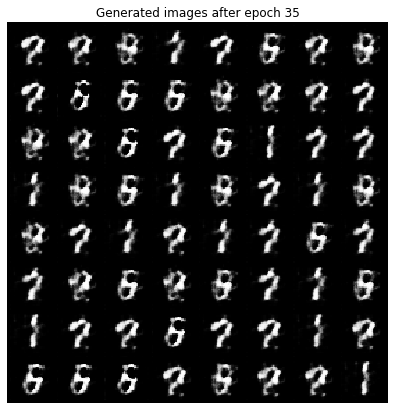

Saved checkpoint at epoch:  35
[36/140]	D_loss: -0.62,	G_loss: -0.11,	[GP: 0.04, Gradient norm: 0.97]
[37/140]	D_loss: -0.59,	G_loss: -0.10,	[GP: 0.07, Gradient norm: 0.98]
[38/140]	D_loss: -0.64,	G_loss: -0.10,	[GP: 0.03, Gradient norm: 1.01]
[39/140]	D_loss: -0.57,	G_loss: -0.20,	[GP: 0.04, Gradient norm: 1.00]
[40/140]	D_loss: -0.60,	G_loss: -0.17,	[GP: 0.05, Gradient norm: 0.98]


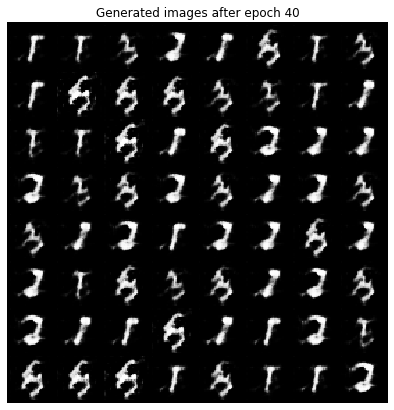

Saved checkpoint at epoch:  40
[41/140]	D_loss: -0.67,	G_loss: -0.15,	[GP: 0.02, Gradient norm: 0.99]
[42/140]	D_loss: -0.62,	G_loss: -0.11,	[GP: 0.04, Gradient norm: 0.97]
[43/140]	D_loss: -0.56,	G_loss: -0.16,	[GP: 0.07, Gradient norm: 1.00]
[44/140]	D_loss: -0.63,	G_loss: -0.18,	[GP: 0.03, Gradient norm: 0.99]
[45/140]	D_loss: -0.58,	G_loss: -0.16,	[GP: 0.10, Gradient norm: 1.00]


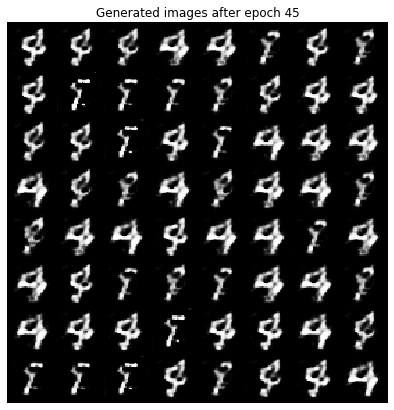

Saved checkpoint at epoch:  45
[46/140]	D_loss: -0.60,	G_loss: -0.13,	[GP: 0.05, Gradient norm: 1.04]
[47/140]	D_loss: -0.45,	G_loss: -0.19,	[GP: 0.31, Gradient norm: 0.98]
[48/140]	D_loss: -0.55,	G_loss: -0.16,	[GP: 0.10, Gradient norm: 0.99]
[49/140]	D_loss: -0.62,	G_loss: -0.16,	[GP: 0.05, Gradient norm: 1.01]
[50/140]	D_loss: -0.50,	G_loss: -0.15,	[GP: 0.04, Gradient norm: 1.01]


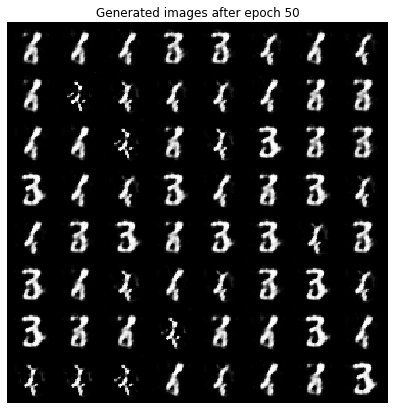

Saved checkpoint at epoch:  50
[51/140]	D_loss: -0.62,	G_loss: -0.10,	[GP: 0.07, Gradient norm: 1.00]
[52/140]	D_loss: -0.65,	G_loss: -0.19,	[GP: 0.07, Gradient norm: 1.01]
[53/140]	D_loss: -0.58,	G_loss: -0.13,	[GP: 0.08, Gradient norm: 1.02]
[54/140]	D_loss: -0.45,	G_loss: -0.13,	[GP: 0.17, Gradient norm: 0.97]
[55/140]	D_loss: -0.49,	G_loss: -0.22,	[GP: 0.09, Gradient norm: 1.03]


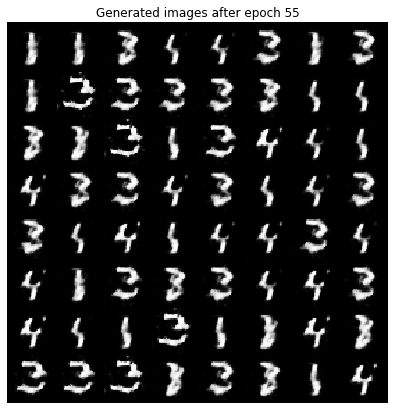

Saved checkpoint at epoch:  55
[56/140]	D_loss: -0.64,	G_loss: -0.16,	[GP: 0.02, Gradient norm: 1.00]
[57/140]	D_loss: -0.71,	G_loss: -0.17,	[GP: 0.03, Gradient norm: 0.99]
[58/140]	D_loss: -0.69,	G_loss: -0.14,	[GP: 0.02, Gradient norm: 0.99]
[59/140]	D_loss: -0.60,	G_loss: -0.23,	[GP: 0.08, Gradient norm: 0.99]
[60/140]	D_loss: -0.42,	G_loss: -0.36,	[GP: 0.04, Gradient norm: 0.99]


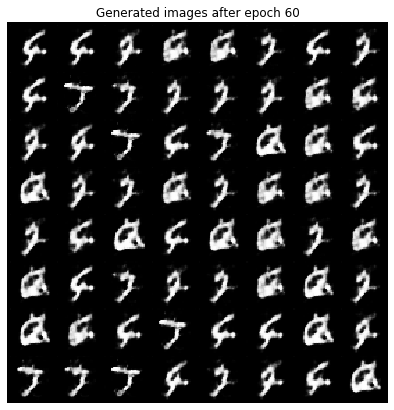

Saved checkpoint at epoch:  60
[61/140]	D_loss: -0.54,	G_loss: -0.21,	[GP: 0.09, Gradient norm: 0.96]
[62/140]	D_loss: -0.58,	G_loss: -0.17,	[GP: 0.05, Gradient norm: 0.98]
[63/140]	D_loss: -0.56,	G_loss: -0.17,	[GP: 0.08, Gradient norm: 0.99]
[64/140]	D_loss: -0.54,	G_loss: -0.15,	[GP: 0.09, Gradient norm: 0.99]
[65/140]	D_loss: -0.53,	G_loss: -0.11,	[GP: 0.06, Gradient norm: 1.02]


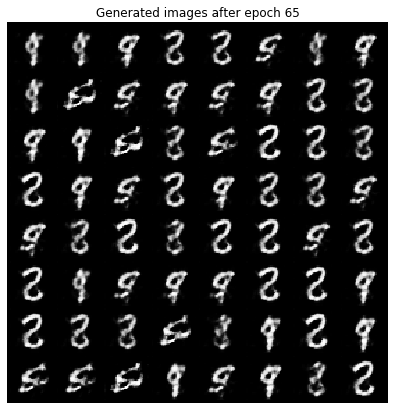

Saved checkpoint at epoch:  65
[66/140]	D_loss: 3.39,	G_loss: -0.20,	[GP: 3.89, Gradient norm: 1.10]
[67/140]	D_loss: -0.45,	G_loss: -0.07,	[GP: 0.33, Gradient norm: 0.96]
[68/140]	D_loss: -0.64,	G_loss: -0.17,	[GP: 0.06, Gradient norm: 1.00]
[69/140]	D_loss: -0.64,	G_loss: -0.11,	[GP: 0.06, Gradient norm: 1.00]
[70/140]	D_loss: -0.60,	G_loss: -0.17,	[GP: 0.05, Gradient norm: 1.01]


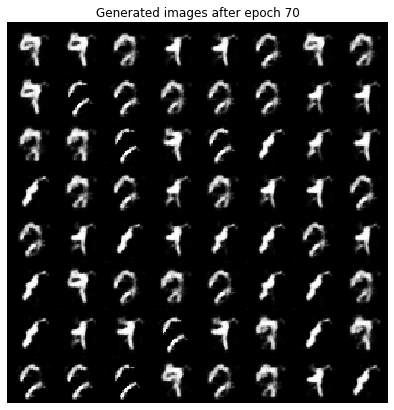

Saved checkpoint at epoch:  70
Saved checkpoint at epoch:  70
[71/140]	D_loss: -0.62,	G_loss: -0.13,	[GP: 0.07, Gradient norm: 0.99]
[72/140]	D_loss: -0.64,	G_loss: -0.08,	[GP: 0.03, Gradient norm: 1.00]
[73/140]	D_loss: -0.45,	G_loss: -0.16,	[GP: 0.24, Gradient norm: 0.96]
[74/140]	D_loss: -0.64,	G_loss: -0.17,	[GP: 0.06, Gradient norm: 0.99]
[75/140]	D_loss: -0.57,	G_loss: -0.13,	[GP: 0.15, Gradient norm: 1.02]


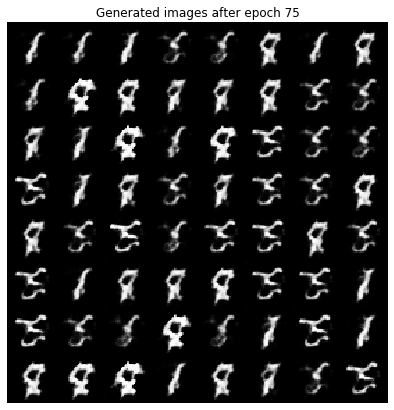

Saved checkpoint at epoch:  75
[76/140]	D_loss: -0.59,	G_loss: -0.16,	[GP: 0.03, Gradient norm: 1.03]
[77/140]	D_loss: -0.55,	G_loss: -0.22,	[GP: 0.02, Gradient norm: 1.00]
[78/140]	D_loss: -0.67,	G_loss: -0.13,	[GP: 0.05, Gradient norm: 1.01]
[79/140]	D_loss: -0.52,	G_loss: -0.13,	[GP: 0.03, Gradient norm: 1.00]
[80/140]	D_loss: -0.49,	G_loss: -0.14,	[GP: 0.20, Gradient norm: 0.97]


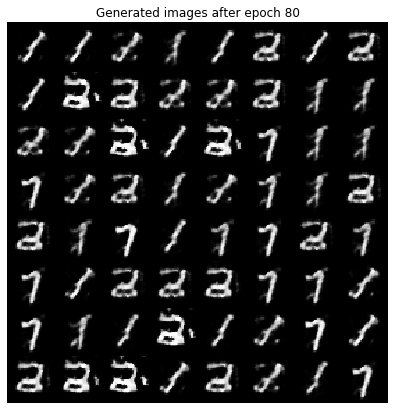

Saved checkpoint at epoch:  80
[81/140]	D_loss: -0.45,	G_loss: -0.17,	[GP: 0.19, Gradient norm: 1.01]
[82/140]	D_loss: -0.66,	G_loss: -0.15,	[GP: 0.04, Gradient norm: 0.98]
[83/140]	D_loss: -0.65,	G_loss: -0.09,	[GP: 0.02, Gradient norm: 1.00]
[84/140]	D_loss: -0.58,	G_loss: -0.22,	[GP: 0.08, Gradient norm: 1.00]
[85/140]	D_loss: -0.75,	G_loss: -0.13,	[GP: 0.03, Gradient norm: 1.01]


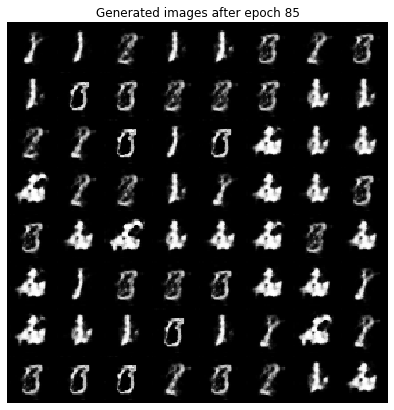

Saved checkpoint at epoch:  85
[86/140]	D_loss: -0.52,	G_loss: -0.21,	[GP: 0.05, Gradient norm: 1.02]
[87/140]	D_loss: -0.68,	G_loss: -0.15,	[GP: 0.02, Gradient norm: 0.99]
[88/140]	D_loss: -0.59,	G_loss: -0.12,	[GP: 0.14, Gradient norm: 1.04]
[89/140]	D_loss: -0.52,	G_loss: -0.17,	[GP: 0.04, Gradient norm: 0.99]
[90/140]	D_loss: -0.68,	G_loss: -0.12,	[GP: 0.05, Gradient norm: 1.02]


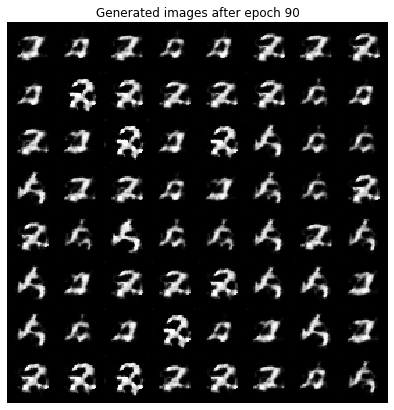

Saved checkpoint at epoch:  90
[91/140]	D_loss: -0.63,	G_loss: -0.10,	[GP: 0.09, Gradient norm: 0.98]
[92/140]	D_loss: -0.68,	G_loss: -0.12,	[GP: 0.08, Gradient norm: 1.01]
[93/140]	D_loss: -0.56,	G_loss: -0.13,	[GP: 0.15, Gradient norm: 0.97]
[94/140]	D_loss: -0.67,	G_loss: -0.11,	[GP: 0.03, Gradient norm: 1.02]
[95/140]	D_loss: -0.54,	G_loss: -0.26,	[GP: 0.02, Gradient norm: 0.97]


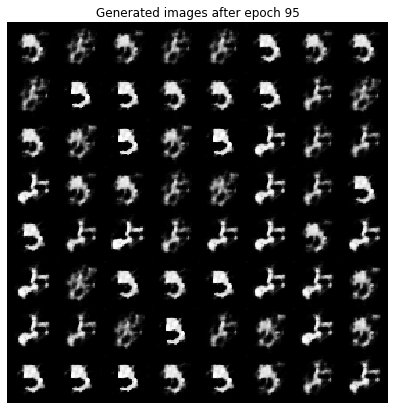

Saved checkpoint at epoch:  95
[96/140]	D_loss: -0.68,	G_loss: -0.13,	[GP: 0.07, Gradient norm: 1.00]
[97/140]	D_loss: -0.72,	G_loss: -0.15,	[GP: 0.07, Gradient norm: 1.01]
[98/140]	D_loss: -0.52,	G_loss: -0.12,	[GP: 0.09, Gradient norm: 1.02]
[99/140]	D_loss: -0.50,	G_loss: -0.14,	[GP: 0.06, Gradient norm: 1.03]
[100/140]	D_loss: -0.44,	G_loss: -0.14,	[GP: 0.30, Gradient norm: 0.98]


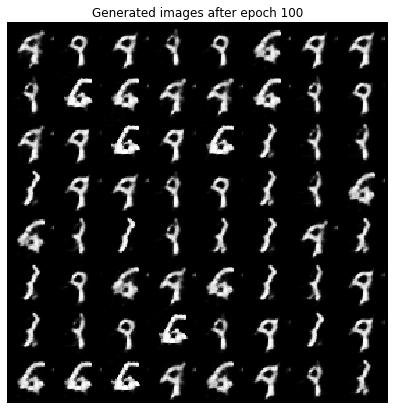

Saved checkpoint at epoch:  100
[101/140]	D_loss: -0.62,	G_loss: -0.16,	[GP: 0.02, Gradient norm: 1.00]
[102/140]	D_loss: -0.51,	G_loss: -0.22,	[GP: 0.05, Gradient norm: 1.01]
[103/140]	D_loss: -0.71,	G_loss: -0.14,	[GP: 0.01, Gradient norm: 0.99]
[104/140]	D_loss: -0.59,	G_loss: -0.11,	[GP: 0.03, Gradient norm: 1.00]
[105/140]	D_loss: -0.65,	G_loss: -0.13,	[GP: 0.04, Gradient norm: 1.00]


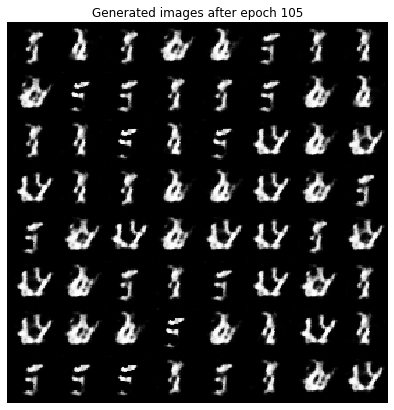

Saved checkpoint at epoch:  105
[106/140]	D_loss: -0.51,	G_loss: -0.21,	[GP: 0.05, Gradient norm: 1.01]
[107/140]	D_loss: -0.57,	G_loss: -0.08,	[GP: 0.02, Gradient norm: 1.00]
[108/140]	D_loss: -0.45,	G_loss: -0.14,	[GP: 0.19, Gradient norm: 1.02]
[109/140]	D_loss: -0.61,	G_loss: -0.13,	[GP: 0.08, Gradient norm: 1.01]
[110/140]	D_loss: -0.62,	G_loss: -0.13,	[GP: 0.05, Gradient norm: 0.98]


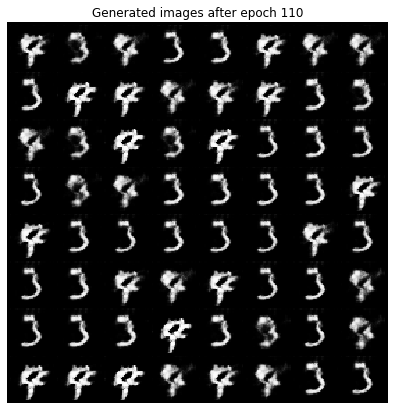

Saved checkpoint at epoch:  110
[111/140]	D_loss: -0.55,	G_loss: -0.21,	[GP: 0.09, Gradient norm: 0.97]
[112/140]	D_loss: -0.53,	G_loss: -0.12,	[GP: 0.06, Gradient norm: 0.99]
[113/140]	D_loss: -0.59,	G_loss: -0.13,	[GP: 0.08, Gradient norm: 0.99]
[114/140]	D_loss: -0.71,	G_loss: -0.13,	[GP: 0.02, Gradient norm: 0.99]
[115/140]	D_loss: -0.75,	G_loss: -0.13,	[GP: 0.03, Gradient norm: 0.99]


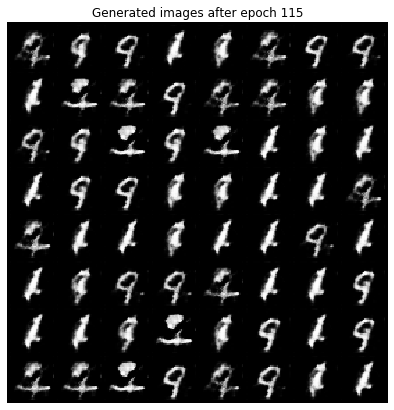

Saved checkpoint at epoch:  115
[116/140]	D_loss: -0.33,	G_loss: -0.11,	[GP: 0.34, Gradient norm: 0.95]
[117/140]	D_loss: -0.65,	G_loss: -0.12,	[GP: 0.03, Gradient norm: 1.00]
[118/140]	D_loss: -0.33,	G_loss: -0.11,	[GP: 0.44, Gradient norm: 1.03]
[119/140]	D_loss: -0.62,	G_loss: -0.06,	[GP: 0.08, Gradient norm: 0.98]
[120/140]	D_loss: -0.67,	G_loss: -0.15,	[GP: 0.06, Gradient norm: 1.01]


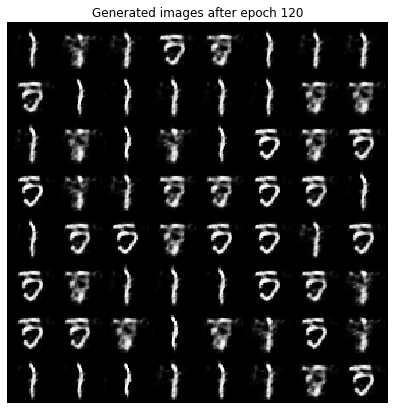

Saved checkpoint at epoch:  120
[121/140]	D_loss: -0.69,	G_loss: -0.14,	[GP: 0.05, Gradient norm: 1.01]
[122/140]	D_loss: -0.50,	G_loss: -0.12,	[GP: 0.17, Gradient norm: 1.01]
[123/140]	D_loss: -0.69,	G_loss: -0.09,	[GP: 0.03, Gradient norm: 1.01]


In [0]:
# Initialize optimizers
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# Train model
model = GAN(generator, discriminator, G_optimizer, D_optimizer, use_cuda=torch.cuda.is_available())
model.train(dataloader, epochs, show_results=True)

#Load Model if you don't train
#model.restore_checkpoint(checkpoint_file) ;

In [0]:
model.plot_save_generated(199, save=True)